In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

Load model and dataset

In [2]:
from src.dataset import get_data

train_loader, val_loader, test_loader = get_data()

2025-06-14 10:02:06.828 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Git\fmnist-classification


In [3]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
summary(model, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 112, 112]        864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 112, 112]        64
|    |    └─SiLU: 3-3                         [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 16, 112, 112]        --
|    |    └─MBConv: 3-4                       [-1, 16, 112, 112]        1,448
|    └─Sequential: 2-3                        [-1, 24, 56, 56]          --
|    |    └─MBConv: 3-5                       [-1, 24, 56, 56]          6,004
|    |    └─MBConv: 3-6                       [-1, 24, 56, 56]          10,710
|    └─Sequential: 2-4                        [-1, 40, 28, 28]          --
|    |    └─MBConv: 3-7                       [-1, 40, 28, 28]          15,350
|    

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 112, 112]        864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 112, 112]        64
|    |    └─SiLU: 3-3                         [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 16, 112, 112]        --
|    |    └─MBConv: 3-4                       [-1, 16, 112, 112]        1,448
|    └─Sequential: 2-3                        [-1, 24, 56, 56]          --
|    |    └─MBConv: 3-5                       [-1, 24, 56, 56]          6,004
|    |    └─MBConv: 3-6                       [-1, 24, 56, 56]          10,710
|    └─Sequential: 2-4                        [-1, 40, 28, 28]          --
|    |    └─MBConv: 3-7                       [-1, 40, 28, 28]          15,350
|    

In [4]:
num_features = model.classifier[1].in_features
num_classes = 10

model.classifier = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(num_features, num_classes)
    )

Stage 1: Freeze base model parameters and train only the classifier head

In [5]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [6]:
from src.modeling.train import train_model

model, history1 = train_model(model, train_loader, val_loader, num_epochs=8, lr=0.001)

Epoch 1/8: 100%|██████████| 750/750 [01:24<00:00,  8.87it/s]


Epoch [1/8]:
  Train Loss: 0.7487, Train Acc: 76.35%
  Val Loss: 0.5193, Val Acc: 82.25%


Epoch 2/8: 100%|██████████| 750/750 [01:23<00:00,  8.95it/s]


Epoch [2/8]:
  Train Loss: 0.5582, Train Acc: 80.43%
  Val Loss: 0.4646, Val Acc: 83.56%


Epoch 3/8: 100%|██████████| 750/750 [01:22<00:00,  9.12it/s]


Epoch [3/8]:
  Train Loss: 0.5255, Train Acc: 81.46%
  Val Loss: 0.4613, Val Acc: 83.78%


Epoch 4/8: 100%|██████████| 750/750 [01:18<00:00,  9.51it/s]


Epoch [4/8]:
  Train Loss: 0.5081, Train Acc: 81.85%
  Val Loss: 0.4364, Val Acc: 84.44%


Epoch 5/8: 100%|██████████| 750/750 [01:16<00:00,  9.81it/s]


Epoch [5/8]:
  Train Loss: 0.5007, Train Acc: 82.21%
  Val Loss: 0.4372, Val Acc: 84.24%


Epoch 6/8: 100%|██████████| 750/750 [01:16<00:00,  9.78it/s]


Epoch [6/8]:
  Train Loss: 0.4942, Train Acc: 82.25%
  Val Loss: 0.4339, Val Acc: 84.01%


Epoch 7/8: 100%|██████████| 750/750 [01:16<00:00,  9.81it/s]


Epoch [7/8]:
  Train Loss: 0.4932, Train Acc: 82.43%
  Val Loss: 0.4298, Val Acc: 84.22%


Epoch 8/8: 100%|██████████| 750/750 [01:17<00:00,  9.74it/s]


Epoch [8/8]:
  Train Loss: 0.4848, Train Acc: 82.61%
  Val Loss: 0.4220, Val Acc: 84.35%


Stage 2: Unfreeze and fine-tune the entire model 

In [7]:
for param in model.parameters():
    param.requires_grad = True

In [8]:
model, history2 = train_model(model, train_loader, val_loader, 
                                 num_epochs=10, lr=0.0005)

Epoch 1/10: 100%|██████████| 750/750 [02:21<00:00,  5.29it/s]


Epoch [1/10]:
  Train Loss: 0.2930, Train Acc: 89.57%
  Val Loss: 0.2221, Val Acc: 91.89%


Epoch 2/10: 100%|██████████| 750/750 [02:22<00:00,  5.26it/s]


Epoch [2/10]:
  Train Loss: 0.1938, Train Acc: 92.87%
  Val Loss: 0.1811, Val Acc: 93.56%


Epoch 3/10: 100%|██████████| 750/750 [02:21<00:00,  5.30it/s]


Epoch [3/10]:
  Train Loss: 0.1618, Train Acc: 94.15%
  Val Loss: 0.1774, Val Acc: 93.70%


Epoch 4/10: 100%|██████████| 750/750 [02:23<00:00,  5.21it/s]


Epoch [4/10]:
  Train Loss: 0.1420, Train Acc: 94.82%
  Val Loss: 0.1671, Val Acc: 94.12%


Epoch 5/10: 100%|██████████| 750/750 [02:23<00:00,  5.22it/s]


Epoch [5/10]:
  Train Loss: 0.1293, Train Acc: 95.31%
  Val Loss: 0.1855, Val Acc: 93.77%


Epoch 6/10: 100%|██████████| 750/750 [02:22<00:00,  5.27it/s]


Epoch [6/10]:
  Train Loss: 0.1136, Train Acc: 95.88%
  Val Loss: 0.1765, Val Acc: 93.78%


Epoch 7/10: 100%|██████████| 750/750 [02:22<00:00,  5.28it/s]


Epoch [7/10]:
  Train Loss: 0.1044, Train Acc: 96.12%
  Val Loss: 0.1651, Val Acc: 94.35%


Epoch 8/10: 100%|██████████| 750/750 [02:19<00:00,  5.36it/s]


Epoch [8/10]:
  Train Loss: 0.0935, Train Acc: 96.53%
  Val Loss: 0.1837, Val Acc: 94.37%


Epoch 9/10: 100%|██████████| 750/750 [02:17<00:00,  5.44it/s]


Epoch [9/10]:
  Train Loss: 0.0847, Train Acc: 96.84%
  Val Loss: 0.1819, Val Acc: 94.39%


Epoch 10/10: 100%|██████████| 750/750 [02:16<00:00,  5.49it/s]


Epoch [10/10]:
  Train Loss: 0.0766, Train Acc: 97.20%
  Val Loss: 0.1723, Val Acc: 94.63%


In [9]:
import matplotlib.pyplot as plt 

def plot_training_history(history1, history2):
    # Combine histories from both stages
    train_loss = history1["train_loss"] + history2["train_loss"]
    train_acc = history1["train_accuracy"] + history2["train_accuracy"]
    val_loss = history1["val_loss"] + history2["val_loss"]
    val_acc = history1["val_accuracy"] + history2["val_accuracy"]
    
    epochs = range(1, len(train_loss) + 1)
    stage1_epochs = len(history1["train_loss"])
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    ax1.axvline(x=stage1_epochs + 0.5, color='gray', linestyle='--', alpha=0.7, 
                label='Stage 1 → Stage 2')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add stage annotations
    ax1.text(stage1_epochs/2, max(train_loss) * 0.9, 'Stage 1\n(Classifier Only)', 
             ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    ax1.text(stage1_epochs + (len(epochs) - stage1_epochs)/2, max(train_loss) * 0.9, 
             'Stage 2\n(Fine-tuning)', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    # Plot Accuracy
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.axvline(x=stage1_epochs + 0.5, color='gray', linestyle='--', alpha=0.7,
                label='Stage 1 → Stage 2')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add stage annotations
    ax2.text(stage1_epochs/2, min(train_acc) + (max(train_acc) - min(train_acc)) * 0.1, 
             'Stage 1\n(Classifier Only)', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    ax2.text(stage1_epochs + (len(epochs) - stage1_epochs)/2, 
             min(train_acc) + (max(train_acc) - min(train_acc)) * 0.1, 
             'Stage 2\n(Fine-tuning)', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"Stage 1 - Final Train Acc: {history1['train_accuracy'][-1]:.2f}%, Val Acc: {history1['val_accuracy'][-1]:.2f}%")
    print(f"Stage 2 - Final Train Acc: {history2['train_accuracy'][-1]:.2f}%, Val Acc: {history2['val_accuracy'][-1]:.2f}%")
    print(f"Best Validation Accuracy: {max(val_acc):.2f}%")

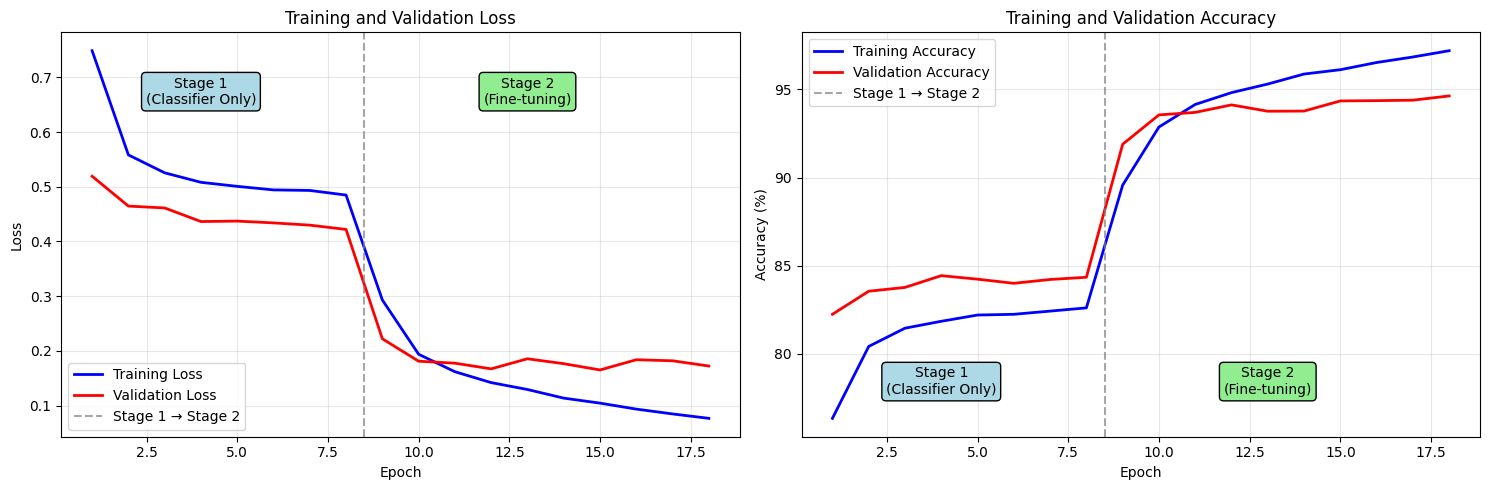

Stage 1 - Final Train Acc: 82.61%, Val Acc: 84.35%
Stage 2 - Final Train Acc: 97.20%, Val Acc: 94.63%
Best Validation Accuracy: 94.63%


In [10]:
plot_training_history(history1, history2)

In [12]:
from sklearn.metrics import accuracy_score

model.eval()

all_predictions = []
all_labels = []

device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Accuracy: 0.9431 (94.31%)
